In [10]:
import pandas as pd

df = pd.read_csv('raw_training_df.csv')
df.set_index('genes', inplace=True)
df = df.T

metadata = pd.read_csv('metadata.csv')
metadata = metadata.set_index('sample_id')

import scanpy as sc

adata = sc.AnnData(df)
adata.obs = adata.obs.merge(metadata, left_index=True, right_index=True, how='left')

In [30]:
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Custom Dataset for AnnData
class AnnDataset(Dataset):
    def __init__(self, adata):
        self.data = adata.X

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx, :], dtype=torch.float32)  # Assuming sparse matrix

In [65]:
# Convert adata to a PyTorch DataLoader
batch_size = 32
dataset = AnnDataset(adata)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [1]:
import torch
from typing import Literal

class MyNeuralNet(torch.nn.Module):
    def __init__(
        self,
        n_input: int = 10,
        n_output: int = 10,
        n_layer: int = 3,
        n_hidden: int = 128,
        act_fn: Literal["relu", "tanh", "sigmoid"] = "relu",
        final_transf: Literal["exp", "none", "softmax"] = "none",
    ):
        """
        Encodes data of ``n_input`` dimensions into a space of ``n_output`` dimensions.

        Uses a fully-connected neural network with specified number of hidden layers and nodes.

        Parameters
        ----------
        n_input
            The dimensionality of the input (default: 10)
        n_output
            The dimensionality of the output (default: 2)
        n_layer
            The number of hidden layers (default: 3)
        n_hidden
            The number of nodes in each hidden layer (default: 128)
        act_fn
            The activation function for the hidden layers (default: "relu")
        final_transf
            The final non-linearity applied to the output layer (default: "none")
        """
        super().__init__()

        # Determine the activation function for hidden layers
        if act_fn == "relu":
            activation = torch.nn.ReLU()
        elif act_fn == "tanh":
            activation = torch.nn.Tanh()
        elif act_fn == "sigmoid":
            activation = torch.nn.Sigmoid()
        else:
            raise ValueError("Unsupported activation function: choose from 'relu', 'tanh', 'sigmoid'")

        layers = []
        input_dim = n_input

        # Create hidden layers with specified activation function and number of nodes
        for _ in range(n_layer):
            layers.append(torch.nn.Linear(input_dim, n_hidden))
            layers.append(activation)
            input_dim = n_hidden
        
        # Output layer
        layers.append(torch.nn.Linear(input_dim, n_output))
        
        # Create the neural network
        self.neural_net = torch.nn.Sequential(*layers)

        # Final transformation
        self.transformation = None
        if final_transf == "softmax":
            self.transformation = torch.nn.Softmax(dim=-1)
        elif final_transf == "exp":
            self.transformation = torch.exp

    def forward(self, x: torch.Tensor):
        output = self.neural_net(x)
        if self.transformation:
            output = self.transformation(output)
        return output

In [78]:
from torch.distributions import NegativeBinomial, Normal
from torch.distributions import kl_divergence 

class MyVAE(torch.nn.Module):
    def __init__(self, n_input: int, n_latent: int = 10, n_layer: int = 3, n_hidden: int = 128):
        super().__init__()
        # self.n_latent = n_latent

        # Encoder: q(z|x)
        self.mean_encoder = MyNeuralNet(n_input, n_latent, n_layer, n_hidden)
        self.var_encoder = MyNeuralNet(n_input, n_latent, n_layer, n_hidden, final_transf = "exp")

        # Decoder: p(x|z)
        self.decoder = MyNeuralNet(n_latent, n_input, n_layer, n_hidden, final_transf = "softmax")

        # Dispersion parameter for Negative Binomial
        self.log_theta = torch.nn.Parameter(torch.randn(n_input))

    def inference(self, tensors):
        x = tensors['X']
        # Log-transform the input for numerical stability
        x = torch.log1p(x)
        # get mu and var
        qz_m = self.mean_encoder(x)
        qz_v = self.var_encoder(x)
        
        # logvar = self.var_encoder(x)  # Outputs log-variance
        # qz_v = torch.exp(logvar)  # Exponentiate to ensure positive variance
        
        z = Normal(qz_m, torch.sqrt(qz_v)).rsample()
        return {"qz_m": qz_m, "qz_v": qz_v, "z": z}

    def generative(self, inference_outputs):
        z = inference_outputs['z']
        px_scale = self.decoder(z)
        px_rate = 1 * px_scale
        theta = torch.exp(self.log_theta)
        return {"px_scale": px_scale, "px_rate": px_rate, "theta": theta}

    def loss(self, tensors, inference_outputs, generative_outputs):
        x = tensors['X']
        px_rate = generative_outputs["px_rate"]
        theta = generative_outputs["theta"]
        qz_m = inference_outputs["qz_m"]
        qz_v = inference_outputs["qz_v"]

        # Compute the log likelihood term
        nb_logits = (px_rate + 1e-4).log() - (theta + 1e-4).log()
        log_lik = NegativeBinomial(total_count=theta, logits=nb_logits).log_prob(x).sum(dim=-1)

        # Compute the KL divergence term
        prior_dist = Normal(torch.zeros_like(qz_m), torch.ones_like(qz_v))
        var_post_dist = Normal(qz_m, torch.sqrt(qz_v))
        kl_divergence_term = kl_divergence(var_post_dist, prior_dist).sum(dim=1)

        # Compute the ELBO
        elbo = log_lik - kl_divergence_term
        loss = torch.mean(-elbo)
        return {"loss": loss, "reconstruction_loss": -log_lik, "kl_divergence_loss": kl_divergence_term}

In [79]:
from tqdm import tqdm

# Training function
def train(model, dataloader, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            tensors = {'X': batch}
            
            # Perform inference to get latent variables
            inference_outputs = model.inference(tensors)
            
            # Prepare inputs for the generative model
            z = inference_outputs["z"]
            library = torch.sum(tensors['X'], dim=1, keepdim=True)
            
            # Perform the generative step
            generative_outputs = model.generative(inference_outputs)
            
            # Compute the loss
            loss = model.loss(tensors, inference_outputs, generative_outputs)["loss"]
            
            # Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


In [91]:
# Example usage
n_input = dataset.data.shape[1]  # Number of input genes
n_latent = 3  # Dimensionality of the latent space
n_layer = 3
n_hidden = 128

# Create the VAE model
vae_model = MyVAE(n_input, n_latent, n_layer, n_hidden)

import torch.optim as optim

# Example optimizer
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

# Train the model
train(vae_model, dataloader, optimizer, num_epochs=30)

Epoch 1/30: 100%|██████████| 18/18 [00:00<00:00, 62.79it/s]


Epoch 1, Loss: 224752240.0000


Epoch 2/30: 100%|██████████| 18/18 [00:00<00:00, 63.85it/s]


Epoch 2, Loss: 211028778.6667


Epoch 3/30: 100%|██████████| 18/18 [00:00<00:00, 63.24it/s]


Epoch 3, Loss: 211880644.4444


Epoch 4/30: 100%|██████████| 18/18 [00:00<00:00, 62.40it/s]


Epoch 4, Loss: 210073183.1111


Epoch 5/30: 100%|██████████| 18/18 [00:00<00:00, 54.38it/s]


Epoch 5, Loss: 207767319.1111


Epoch 6/30: 100%|██████████| 18/18 [00:00<00:00, 66.17it/s]


Epoch 6, Loss: 206614093.3333


Epoch 7/30: 100%|██████████| 18/18 [00:00<00:00, 63.07it/s]


Epoch 7, Loss: 204821875.5556


Epoch 8/30: 100%|██████████| 18/18 [00:00<00:00, 63.60it/s]


Epoch 8, Loss: 203111361.7778


Epoch 9/30: 100%|██████████| 18/18 [00:00<00:00, 64.27it/s]


Epoch 9, Loss: 202505453.3333


Epoch 10/30: 100%|██████████| 18/18 [00:00<00:00, 68.28it/s]


Epoch 10, Loss: 201308811.5556


Epoch 11/30: 100%|██████████| 18/18 [00:00<00:00, 62.10it/s]


Epoch 11, Loss: 200338810.6667


Epoch 12/30: 100%|██████████| 18/18 [00:00<00:00, 61.91it/s]


Epoch 12, Loss: 199220084.4444


Epoch 13/30: 100%|██████████| 18/18 [00:00<00:00, 64.07it/s]


Epoch 13, Loss: 199460485.3333


Epoch 14/30: 100%|██████████| 18/18 [00:00<00:00, 65.02it/s]


Epoch 14, Loss: 200657973.3333


Epoch 15/30: 100%|██████████| 18/18 [00:00<00:00, 65.52it/s]


Epoch 15, Loss: 197612209.7778


Epoch 16/30: 100%|██████████| 18/18 [00:00<00:00, 67.32it/s]


Epoch 16, Loss: 198695210.6667


Epoch 17/30: 100%|██████████| 18/18 [00:00<00:00, 64.80it/s]


Epoch 17, Loss: 199107430.2222


Epoch 18/30: 100%|██████████| 18/18 [00:00<00:00, 65.00it/s]


Epoch 18, Loss: 196987549.3333


Epoch 19/30: 100%|██████████| 18/18 [00:00<00:00, 64.74it/s]


Epoch 19, Loss: 197315493.3333


Epoch 20/30: 100%|██████████| 18/18 [00:00<00:00, 67.13it/s]


Epoch 20, Loss: 196719504.0000


Epoch 21/30: 100%|██████████| 18/18 [00:00<00:00, 66.16it/s]


Epoch 21, Loss: 196000829.3333


Epoch 22/30: 100%|██████████| 18/18 [00:00<00:00, 66.77it/s]


Epoch 22, Loss: 195136483.5556


Epoch 23/30: 100%|██████████| 18/18 [00:00<00:00, 64.71it/s]


Epoch 23, Loss: 194204413.3333


Epoch 24/30: 100%|██████████| 18/18 [00:00<00:00, 67.42it/s]


Epoch 24, Loss: 194562527.1111


Epoch 25/30: 100%|██████████| 18/18 [00:00<00:00, 65.93it/s]


Epoch 25, Loss: 193676080.8889


Epoch 26/30: 100%|██████████| 18/18 [00:00<00:00, 62.69it/s]


Epoch 26, Loss: 194751963.5556


Epoch 27/30: 100%|██████████| 18/18 [00:00<00:00, 63.62it/s]


Epoch 27, Loss: 193952996.4444


Epoch 28/30: 100%|██████████| 18/18 [00:00<00:00, 65.91it/s]


Epoch 28, Loss: 191680486.2222


Epoch 29/30: 100%|██████████| 18/18 [00:00<00:00, 65.80it/s]


Epoch 29, Loss: 192700992.0000


Epoch 30/30: 100%|██████████| 18/18 [00:00<00:00, 67.33it/s]

Epoch 30, Loss: 191650379.5556


In [94]:
def extract_latent_representations(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_latent_representations = []

    with torch.no_grad():
        for batch in dataloader:
            tensors = {'X': batch}
            inference_outputs = model.inference(tensors)
            z = inference_outputs["z"]
            all_latent_representations.append(z.cpu().numpy())
    
    # Concatenate all the latent representations into a single array
    all_latent_representations = np.concatenate(all_latent_representations, axis=0)
    return all_latent_representations

In [93]:
dataloader_for_extraction = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [95]:
# Extract latent representations
latent_representations = extract_latent_representations(vae_model, dataloader)

In [97]:
latent_representations.shape

(554, 3)

In [98]:
scvi_matrix = pd.DataFrame(latent_representations)
scvi_matrix['sample_id'] = df.index
scvi_matrix = scvi_matrix.set_index('sample_id', drop = True)

scvi_matrix.columns = scvi_matrix.columns = ['V' + str(col) for col in scvi_matrix.columns]

In [99]:
# Merge DataFrames by 'sample_id'
scvi_representation_coordinates_merged = pd.merge(scvi_matrix, metadata, on='sample_id')

# Replace NaN with 'NA'
scvi_representation_coordinates_merged.fillna('NA', inplace=True)

In [101]:
scvi_representation_coordinates_merged

,V0,V1,V2,dataset_id,cell_type,parental_cell_type,final_cell_type,disease_state,organism,sample_type,...,prep_method_broad,preparation_method,capture,fragmentation,stranded,sequencing_layout,average_read_length,sequencer,training_atlas,sample_id_without_datasetid
sample_id,,,,,,,,,,,,,,,,,,,,,
1611_GSM2027310,5.454224,35.045856,13.282932,1611,conventional dendritic cell,NA,NA,normal,homo sapiens,cDC2,...,illumina_truseq,Illumina Truseq RNA Sample Prep v2,oligo-dT beads,RNA heat and buffer,non stranded,paired,51,Illumina HiSeq 2000,include,GSM2027310
1611_GSM2027311,-0.480092,37.389317,0.182844,1611,conventional dendritic cell,NA,NA,normal,homo sapiens,cDC1,...,illumina_truseq,Illumina Truseq RNA Sample Prep v2,oligo-dT beads,RNA heat and buffer,non stranded,paired,51,Illumina HiSeq 2000,include,GSM2027311
1611_GSM2027312,-11.506524,-6.668914,40.431561,1611,plasmacytoid dendritic cell,NA,NA,normal,homo sapiens,pDC,...,illumina_truseq,Illumina Truseq RNA Sample Prep v2,oligo-dT beads,RNA heat and buffer,non stranded,paired,51,Illumina HiSeq 2000,include,GSM2027312
1611_GSM2027313,13.114721,12.891708,25.692595,1611,plasmacytoid dendritic cell,NA,NA,normal,homo sapiens,pDC,...,illumina_truseq,Illumina Truseq RNA Sample Prep v2,oligo-dT beads,RNA heat and buffer,non stranded,paired,50,Illumina HiSeq 2000,include,GSM2027313
1611_GSM2027314,-1.283666,37.711197,0.767383,1611,conventional dendritic cell,NA,NA,normal,homo sapiens,cDC2,...,illumina_truseq,Illumina Truseq RNA Sample Prep v2,oligo-dT beads,RNA heat and buffer,non stranded,paired,51,Illumina HiSeq 2000,include,GSM2027314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9798_Kolf2_iMacs_UT_16h_2_01,-34.506855,22.917440,29.765755,9798,macrophage,induced pluripotent stem cell,macrophage,normal,homo sapiens,UT_16h,...,hudson,Hudson,unknown,unknown,unknown,unknown,unknown,unknown,include,Kolf2
9798_Kolf2_iMacs_UT_16h_3_01,2.279631,34.087559,4.961627,9798,macrophage,induced pluripotent stem cell,macrophage,normal,homo sapiens,UT_16h,...,hudson,Hudson,unknown,unknown,unknown,unknown,unknown,unknown,include,Kolf2
9798_Kolf2_iMacs_UT_6h_1_01,-6.345797,31.082340,11.728903,9798,macrophage,induced pluripotent stem cell,macrophage,normal,homo sapiens,UT_6h,...,hudson,Hudson,unknown,unknown,unknown,unknown,unknown,unknown,include,Kolf2


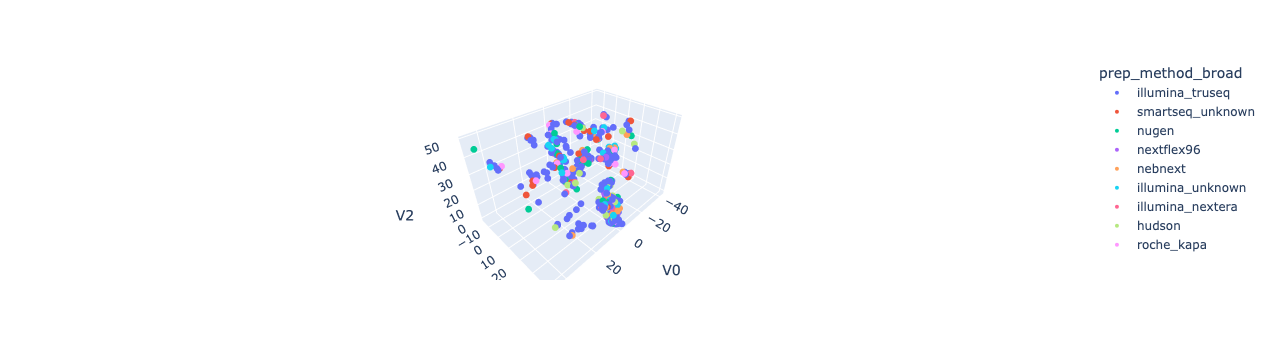

In [104]:
import plotly.express as px

# Plotting
fig = px.scatter_3d(
    scvi_representation_coordinates_merged,
    x='V0',
    y='V1',
    z='V2',
    color= 'prep_method_broad'
    # symbol = 'prep_method_broad'
)

# Adjusting marker size
fig.update_traces(marker=dict(size=4))

# Show the plot
fig.show()